# Class 10 - Responsible AI: Fairness

## Agenda
1. Bias and Fairness

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,  roc_curve, auc

from aequitas import Audit

np.random.seed(0)  # For reproducibility

## Load Data

In [2]:
#data_url = 'https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/MLCatolica24/main/Aula%2010%20-%20%20Responsible%20AI/data/liver_disease.csv'
data_url = 'https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/MLCatolica24/main/Aula%208%20-%20Metrics%20%26%20Model%20Optimization/data/Liver_disease_data.csv'
#df = pd.read_csv(data_url, index_col = 'id')
df = pd.read_csv(data_url)
df.shape

(1700, 11)

In [3]:
df.head(5)

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,0,35.857584,17.272828,0,1,0.658940,0,0,42.734240,1
1,71,1,30.732470,2.201266,0,1,1.670557,1,0,67.309822,1
2,48,0,19.971407,18.500944,0,0,9.928308,0,0,63.738956,0
3,34,1,16.615417,12.632870,0,0,5.630129,0,0,64.555873,1
4,62,1,16.065830,1.087815,0,1,3.566218,1,0,77.868689,1


In [4]:
df['Diagnosis'].value_counts()

Diagnosis
1    936
0    764
Name: count, dtype: int64

## Creating synthetically a new feature

In [5]:
# Function to assign race based on Diagnosis
def assign_race(diagnosis):
    if diagnosis == 1:
        return np.random.choice(['White', 'Non-White'], p=[0.75, 0.25])
    else:
        return np.random.choice(['White', 'Non-White'], p=[0.5, 0.5])

In [6]:
# Apply the function to create the Race column
df['Race'] = df['Diagnosis'].apply(assign_race)

In [7]:
df[df['Diagnosis']==1]['Race'].value_counts()

Race
White        696
Non-White    240
Name: count, dtype: int64

In [8]:
df[df['Diagnosis']==0]['Race'].value_counts()

Race
Non-White    391
White        373
Name: count, dtype: int64

## Prepare data for model training

In [9]:
# Split data into features (X) and target (y)
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

In [11]:
# Standardize continuous variables (assuming continuous columns are 'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'LiverFunctionTest')
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [12]:
continuous_columns = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'LiverFunctionTest']
X_train_scaled[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test_scaled[continuous_columns] = scaler.transform(X_test[continuous_columns])

In [13]:
# Encode categorical variables (Race)
X_train_scaled = pd.get_dummies(X_train_scaled, columns=['Race'], drop_first=True)
X_test_scaled = pd.get_dummies(X_test_scaled, columns=['Race'], drop_first=True)

X_train_scaled['Race_White'] = X_train_scaled['Race_White'].astype(int)
X_test_scaled['Race_White'] = X_test_scaled['Race_White'].astype(int)

In [18]:
X_train.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Race
427,40,1,20.388247,6.353894,0,1,2.624078,0,0,55.364857,White
647,77,1,15.167760,9.654269,1,0,4.132034,0,0,23.434892,Non-White
1152,75,0,24.054406,6.474617,0,0,5.021620,0,0,38.383655,White
206,70,0,27.404160,13.400651,0,0,4.176390,0,0,60.864391,White
1189,66,1,38.730216,15.664309,0,2,4.574616,0,0,71.785638,Non-White


In [17]:
X_train_scaled.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Race_White
427,-0.572980,1,-1.009209,-0.612218,0,1,-0.845307,0,0,-0.200288,1
647,1.515109,1,-1.734112,-0.035173,1,0,-0.315866,0,0,-1.599087,0
1152,1.402240,0,-0.500136,-0.591111,0,0,-0.003534,0,0,-0.944207,1
206,1.120066,0,-0.034998,0.619854,0,0,-0.300293,0,0,0.040638,1
1189,0.894326,1,1.537708,1.015638,0,2,-0.160476,0,0,0.519080,0


In [19]:
# Train a logistic regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [20]:
# Predictions
y_pred = model.predict(X_test_scaled)

In [21]:
# Predictions
y_pred_prob = model.predict_proba(X_test_scaled)[:,1]

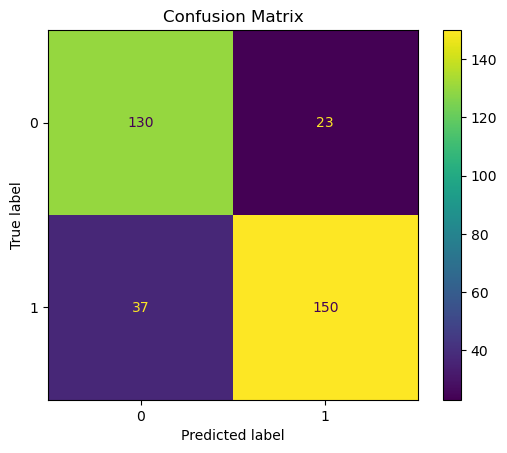

In [22]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [65]:
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

In [35]:
aeq_df = pd.DataFrame()

In [36]:
aeq_df['score'] = y_pred.tolist()

In [38]:
aeq_df['label_value'] = y_test.tolist()

In [41]:
aeq_df['Race'] = X_test['Race'].tolist()

In [44]:
aeq_df.head()

,score,label_value,Race
0,1,0,White
1,1,1,White
2,1,1,Non-White
3,1,1,Non-White
4,1,1,White


In [54]:
aeq_df['Race'].value_counts()

Race
White        215
Non-White    125
Name: count, dtype: int64

In [55]:
aeq_df.describe()

,score,label_value
count,340.000000,340.000000
mean,0.508824,0.550000
std,0.500659,0.498227
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [56]:
# Let's create a confusion matrix separately for each poverty level.
aeq_df_race = aeq_df[aeq_df['Race'] == 'White']
pd.crosstab(aeq_df_race.label_value, aeq_df_race.score)#, normalize='all')#.round(2)*100

score,0,1
label_value,,
0,64,17
1,18,116


In [57]:
# Let's create a confusion matrix separately for each poverty level.
aeq_df_race = aeq_df[aeq_df['Race'] == 'Non-White']
pd.crosstab(aeq_df_race.label_value, aeq_df_race.score)#, normalize='all')#.round(2)*100

score,0,1
label_value,,
0,66,6
1,19,34


In [71]:
# Define the attributes you want to audit, and which group will be the reference group (i.e., the group in relation to which we will compute disparities)
# The definition of the groups is made using a dictionary with the format {'attribute':'reference_group'}; for example: {'gender':'male'}

attributes_and_reference_groups= {'Race': 'White'}

# The code below retrieves the keys of the defined dictionary and selects them as the attributed to perform the audit
attributes_to_audit = list(attributes_and_reference_groups.keys())

In [72]:
# Select the fairness metric(s) you care about.
metrics = ['TPR']

In [73]:
# Define the disparity tolerance, i.e., the interval for which you consider there is parity between the metrics.
# As a rule of thumb, we define there is parity when the disparity does not exceed 1.30

disparity_tolerance = 1.30

In [74]:
# Initialize Aequitas
g = Group()
b = Bias()

# Get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(aeq_df, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=aeq_df, ref_groups_dict=attributes_and_reference_groups)

In [75]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,173,Race,Non-White,0.800000,0.641509,0.916667,0.223529,0.15000,...,0.320000,6,19,66,34,53,72,125,340,0.424000
1,0,binary 0/1,173,Race,White,0.837209,0.865672,0.790123,0.219512,0.12782,...,0.618605,17,18,64,116,134,81,215,340,0.623256


In [76]:
bdf

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,173,Race,Non-White,0.800000,0.641509,0.916667,0.223529,0.15000,...,White,White,White,White,White,White,White,White,White,White
1,0,binary 0/1,173,Race,White,0.837209,0.865672,0.790123,0.219512,0.12782,...,White,White,White,White,White,White,White,White,White,White


In [77]:
# To visualize all the absolute values
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[['attribute_name', 'attribute_value'] + absolute_metrics]

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Race,Non-White,0.800000,0.641509,0.916667,0.223529,0.15000,0.083333,0.358491,0.776471,0.85000,0.231214,0.320000,0.424000
1,Race,White,0.837209,0.865672,0.790123,0.219512,0.12782,0.209877,0.134328,0.780488,0.87218,0.768786,0.618605,0.623256


In [78]:
# for example, absolute values of the chosen metric for the poverty attribute

ap.absolute(bdf, metrics, 'Race', fairness_threshold = disparity_tolerance)

/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  

alt.LayerChart(...)

In [79]:
# for example, disparities for the poverty_level attribute
ap.disparity(bdf, metrics, 'Race', fairness_threshold = disparity_tolerance)

/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  

alt.LayerChart(...)